In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle

print(np.__version__ )
print(tf.__version__ )

1.19.5
2.7.0


In [3]:
colab_base = '/content/drive/MyDrive/ashraful/'
pc_base = './'
base = colab_base

new_dataset_path = base + 'dataset/new/dataset.txt'

input_tokenizer_retrieve = base + 'dataset/new/input-tokenizer.pickle'
target_tokenizer_retrieve = base + 'dataset/new/target-tokenizer.pickle'
target_word_tokenizer_retrieve = base + 'dataset/new/target-tokenizer-word.pickle'

# top_50k_word_file = base + 'dataset/new/top50k.txt'
# top_20k_word_file = base + 'dataset/new/top20k-3.txt'

top_50k_word_file = base + 'dataset/new/top50k-sentiment.txt'
# top_20k_word_file = base + 'dataset/new/top20k-sentiment.txt'

dataset_paths = [top_50k_word_file]

splitted_data_path = base + 'dataset/splited-my-data-lstm'

saved_model_dir_base = base + 'models/LSTM/word-level-new/'

progress_file_path = saved_model_dir_base + 'progress.txt'
input_tokenizer_dir = saved_model_dir_base + 'input-tokenizer.pickle'
target_tokenizer_dir = saved_model_dir_base + 'target-tokenizer.pickle'
example_batch_dir = saved_model_dir_base + 'example_batch.pickle'

word_frequency_dict_file = base + '/dataset/new/word_frequency_dictionary.pickle'
word_frequency_dict_log_file = base + '/dataset/new/word_frequency_dictionary-log.pickle'
word_frequency_dict_sqrt_file = base + '/dataset/new/word_frequency_dictionary-sqrt.pickle'

saved_lite_model_dir = saved_model_dir_base + 'word-level-lstm-sentiment.tflite'
saved_model_dir = saved_model_dir_base + 'word-level-wo-bi.h5'

checkpoint_dir = saved_model_dir_base + 'checkpoint/'

if not os.path.exists(saved_model_dir_base):
    os.makedirs(saved_model_dir_base)

MAX_LEN = 30

In [4]:
try:
    with open(word_frequency_dict_file, mode='rb') as corpus:
        word_frequency_dict = pickle.loads(corpus.read())
except:
    print("Can not open file")

word_frequency_dict["থেকে"]

1.9999995448023715

In [5]:
# Build word tokenizer
with open(top_50k_word_file, encoding='utf-8', mode='r') as word_file:
    words = [line.split(',')[1] for line in word_file.read().strip().split('\n')]

targ_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
targ_lang_tokenizer.fit_on_texts(words)

with open(target_word_tokenizer_retrieve, mode='wb') as data_file:
    pickle.dump(targ_lang_tokenizer, data_file, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
lines = list()

for path in dataset_paths:
    lines.extend(io.open(path, encoding='UTF-8').read().strip().split('\n'))

# lines = list(lines)
# lines.sort()
print(len(lines))

inp_lang = [[char for char in '<' + l.split(',')[0].replace('ঃ\n', '').replace('\n', '') + '>']  for l in lines]
targ_lang = [l.split(',')[1].replace('ঃ\n', '').replace('\n', '') for l in lines]

print(inp_lang[0])
print(targ_lang[0])



676822
['<', 'a', 'b', '>']
আব


In [7]:
# Retrieving

try:
    with open(input_tokenizer_retrieve, mode='rb') as data_file:
        inp_lang_tokenizer = pickle.load(data_file)
    
except:
    print("Not found")
    inp_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    inp_lang_tokenizer.fit_on_texts(inp_lang)

try:
    with open(target_word_tokenizer_retrieve, mode='rb') as data_file:
        targ_lang_tokenizer = pickle.load(data_file)
    
except:
    print("Not found 2 ")
    targ_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    targ_lang_tokenizer.fit_on_texts(targ_lang)

print(len(inp_lang_tokenizer.word_index))
print(len(targ_lang_tokenizer.word_index))


28
50000


In [8]:
# Saving
with open(input_tokenizer_dir, mode='wb') as data_file:
    pickle.dump(inp_lang_tokenizer, data_file, protocol=pickle.HIGHEST_PROTOCOL)

with open(target_tokenizer_dir, mode='wb') as data_file:
    pickle.dump(targ_lang_tokenizer, data_file, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
input_tensor = inp_lang_tokenizer.texts_to_sequences(inp_lang)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post',
                                                        maxlen=12, truncating='post')


target_tensor = targ_lang_tokenizer.texts_to_sequences(targ_lang)
# print(len(target_tensor))
target_tensor = tf.reshape(target_tensor, [-1]).numpy() # Exception means dic does not contain all words
# print(len(target_tensor))

# sample_weight = np.array(list(map(lambda x: word_frequency_dict[targ_lang_tokenizer.index_word[x]],
#                          target_tensor)))

print(len(inp_lang_tokenizer.word_index))
print(len(targ_lang_tokenizer.word_index))

total_chars = len(inp_lang_tokenizer.word_index) + 1
total_words = len(targ_lang_tokenizer.word_index) + 1

# lines = 0
# inp_lang = 0
# targ_lang = 0

# target_tensor = tf.keras.utils.to_categorical(target_tensor, num_classes=total_words)

28
50000


In [10]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = \
            train_test_split(input_tensor, 
                             target_tensor, 
                             test_size=0.2, 
                             random_state=4651)

# print(input_tensor_train.shape, target_tensor_train.shape)
print(input_tensor_train[500])
print(target_tensor_train[500])

# print(input_tensor_val[500])

# BUFFER_SIZE = len(input_tensor_train)
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
# val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

[ 1  4 11  8  7 19 12  8  3  2  0  0]
32715


In [11]:
print(len(train_dataset))
print(len(val_dataset))
print(len(train_dataset)+len(val_dataset))

541457
135365
676822


In [12]:
accuracy_1 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='Accuracy@1', dtype=None)
accuracy_3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Accuracy@3', dtype=None)
accuracy_5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='Accuracy@5', dtype=None)
accuracy_10 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='Accuracy@10', dtype=None)

metrics=[accuracy_1, accuracy_3, accuracy_5, accuracy_10]

In [ ]:

# class MyLoss(tf.keras.losses.Loss):
#     def __init__(self):
#         super().__init__()
#         self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
#     def __call__(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.convert_to_tensor(y_pred)
#         y_true = tf.cast(y_true, y_pred.dtype)
#         # print(y_true)
#         if y_true.shape[0] is not None:
#             freq = tf.reduce_mean(list(map(lambda x: word_frequency_dict[targ_lang_tokenizer.index_word[x]], y_true.numpy())))
#         else:
#             freq = 1
#         # print(freq)
#         return self.loss(y_true, y_pred, freq)
        
# class MyModel(tf.keras.models.Sequential):
#     def __init__(self):
#         super().__init__()
#         self.my_loss = MyLoss()
#     def train_step(self, data):
#         x, y = data
#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)
#             loss = self.my_loss(y, y_pred)

#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         self.compiled_metrics.update_state(y, y_pred)
#         return {m.name: m.result() for m in self.metrics}


In [19]:
# Code 3\
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(total_chars, 32, input_length=12))

model.add(tf.keras.layers.LSTM(128))

# model.add(tf.keras.layers.LSTM(128))

# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(128))
# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64))
# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(32))
# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(total_words, activation='softmax'))
adam = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 32)            928       
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 50001)             1650033   
                                                                 
Total params: 1,760,241
Trainable params: 1,760,241
No

In [14]:
# Loading prev model
model = tf.keras.models.load_model(saved_model_dir)
model.summary()

OSError: ignored

In [ ]:
# checkpoint = tf.train.Checkpoint(model)
# checkpoint.save(checkpoint_dir)

'/content/drive/MyDrive/ashraful/models/LSTM/word-level-new/checkpoint/-1'

In [32]:
# history = model.fit(input_tensor, 
#                     target_tensor, 
#                     sample_weight=sample_weight, 
#                     epochs=5, 
#                     batch_size=128)

history = model.fit(input_tensor_train, 
                    target_tensor_train, 
                    epochs=1, 
                    batch_size=128)

4231/4231 [==============================] - 32s 8ms/step - loss: 0.5577 - Accuracy@1: 0.8302 - Accuracy@3: 0.9663 - Accuracy@5: 0.9867 - Accuracy@10: 0.9962


In [33]:

# Top 50k
# Accuracy@1: 87.72
# Accuracy@3: 98.43
# Accuracy@5: 99.53
model.evaluate(input_tensor_train, target_tensor_train)

16921/16921 [==============================] - 67s 4ms/step - loss: 0.4272 - Accuracy@1: 0.8611 - Accuracy@3: 0.9817 - Accuracy@5: 0.9953 - Accuracy@10: 0.9994


[0.4272442162036896,
 0.8611117601394653,
 0.9816790819168091,
 0.9953052401542664,
 0.9994127154350281]

In [34]:
model.evaluate(input_tensor_val, target_tensor_val)

4231/4231 [==============================] - 17s 4ms/step - loss: 0.8114 - Accuracy@1: 0.7965 - Accuracy@3: 0.9402 - Accuracy@5: 0.9643 - Accuracy@10: 0.9775


[0.8114333748817444,
 0.79648357629776,
 0.9401543736457825,
 0.9642817378044128,
 0.9775052666664124]

In [35]:
# Saving model in h5 format
# print(saved_model_dir)
model.save(saved_model_dir)
# Saving model in pb format
# model.save(saved_model_dir_base+"/new-model")

In [ ]:
predictions = []
probabilities = []
y_true = target_tensor
BATCH_SIZE = 1024
i = 0
while True:
    if i >= len(target_tensor):
        break
    prediction = model.predict(input_tensor[i:i+BATCH_SIZE])
    # print(prediction.shape)
    # print(tf.math.top_k(prediction, 10).values.numpy().shape)
    # prediction = tf.reshape(prediction, [-1])
    probabilities.extend(list(tf.math.top_k(prediction, 10).values.numpy()))
    predictions.extend(list(tf.math.top_k(prediction, 10).indices.numpy()))
    i += BATCH_SIZE
    # break
print(len(predictions))
print(len(probabilities))
print(y_true.shape)

filename = '/content/drive/MyDrive/ashraful/results.npy'
with open(filename, 'wb') as file:
    np.save(file, np.array(predictions))
    np.save(file, np.array(probabilities))
    np.save(file, np.array(y_true))



676822
676822
(676822,)


In [ ]:
filename = '/content/drive/MyDrive/ashraful/results.npy'

with open(filename, 'rb') as file:
    predictions = np.load(file)
    probabilities = np.load(file)
    y_true = np.load(file)
print(predictions.shape)
print(probabilities.shape)
print(y_true.shape)

(676822, 10)
(676822, 10)
(676822,)


In [ ]:
prediction_prob = []
wrong_prediction_prob = []
wrong_words = []
predicted_words = []
input_words = []
# index = 6
# print(predictions[index])
# print(y_true[index])
# print(probabilities[index])
# print(y_true[index] in predictions[index])
c = 0
for i in range(len(predictions)):
    flag = False
    for j in range(len(predictions[i])):
        if predictions[i][j] == y_true[i]:
            prediction_prob.append(probabilities[i][j])
            c+=1
            flag = True
            break
    if flag == False:
        wrong_prediction_prob.append(np.max(probabilities[i]))
        wrong_words.append(targ_lang_tokenizer.index_word[y_true[i]])
        words = []
        for j in range(len(predictions[i])):
            words.append(targ_lang_tokenizer.index_word[predictions[i][j]])
        predicted_words.append(words)
        input_words.append(''.join(inp_lang[i]))

print("Correct", c)
print("Total", len(y_true))
print("Acc 10: ", (c/len(y_true)) * 100)
# print(len(prediction_prob))
# print(len(wrong_prediction_prob))

prediction_prob = np.array(prediction_prob)
wrong_prediction_prob = np.array(wrong_prediction_prob)
predicted_words = np.array(predicted_words)

with open('/content/drive/MyDrive/ashraful/wrong-words.txt', mode='w', encoding='utf-8') as file:
    for i in range(len(wrong_words)):
        # print(input_words[i][1:-1] + ',' + wrong_words[i])
        file.write(input_words[i][1:-1] + ',' + wrong_words[i] + '\n')

# print(wrong_prediction_prob[1:10])
# print(wrong_words[1:10])
# print(predicted_words[1:10])
# print(input_words[1:10])

Correct 676807
Total 676822
Acc 10:  99.99778375998416


Min correct prediction 0.009935761045198888 %
Max Correct prediction 100.0 %
Max wrong Prediction 81.29761219024658 %
Prediction > 4% probability 606409
Prediction > 4% probability are  0.8959851183572274 % of total prediction




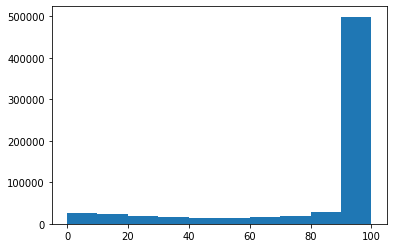

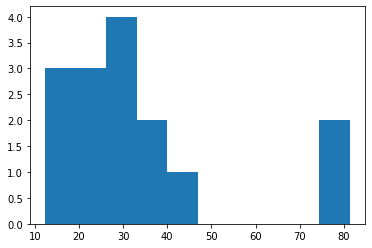

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Min correct prediction", np.min(prediction_prob) * 100 , "%")
print("Max Correct prediction", np.max(prediction_prob) * 100 , "%")

print("Max wrong Prediction", np.max(wrong_prediction_prob) * 100 , "%")
print("Prediction > 4% probability", np.sum(prediction_prob > .30))
print("Prediction > 4% probability are ", np.sum(prediction_prob > .30)/len(prediction_prob), "% of total prediction")
print('\n')

prediction_prob2 = prediction_prob * 100
wrong_prediction_prob2 = wrong_prediction_prob * 100

plt.hist(prediction_prob2)
plt.show()
print('\n')
plt.hist(wrong_prediction_prob2)
plt.show()

In [ ]:
# Saving tf-lite model from keras model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(saved_lite_model_dir, 'wb') as f:
    f.write(tflite_model)

# Or use the following command to convert
# cd /content/drive/MyDrive/ashraful/models/LSTM/word-level/
# tflite_convert --keras_model_file=word-level-lstm.h5 --output_file=word-level-lstm.tflite



In [ ]:
# Saving tf-lite model from saved model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir_2)
tflite_model = converter.convert()

# Save the model.
with open(saved_lite_model_dir, 'wb') as f:
    f.write(tflite_model)

In [ ]:
def preprocess_word(word):
    word = [[char for char in ('<' + word.rstrip().lstrip() + '>')]]
    # print(word)
    word = inp_lang_tokenizer.texts_to_sequences(word)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(word, padding='post',
                                                           maxlen=20, truncating='post')
    return inputs

def evaluate(word, k=3):
    prediction = model.predict(preprocess_word(word))
    print(prediction.shape)
    prediction = tf.reshape(prediction, [-1])
    print(tf.math.top_k(prediction, k))
    prediction_indices = tf.math.top_k(prediction, k).indices.numpy()
    print(prediction_indices)
    prediction = set()
    outputs = []
    for index in prediction_indices:
        if targ_lang_tokenizer.index_word[index] not in prediction:
            prediction.add(targ_lang_tokenizer.index_word[index])
            outputs.append(targ_lang_tokenizer.index_word[index])

    return outputs

In [ ]:
print(evaluate("apply", k=10))

(1, 42623)
TopKV2(values=<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9.9475324e-01, 2.5298016e-03, 1.9258717e-03, 3.4469491e-04,
       1.8014335e-04, 1.5041727e-04, 2.0209982e-05, 1.2323567e-05,
       9.7120710e-06, 8.5324764e-06], dtype=float32)>, indices=<tf.Tensor: shape=(10,), dtype=int32, numpy=
array([23107,  7692, 36770,  8407, 29971, 31561,  7017,  4961, 22765,
       28451], dtype=int32)>)
[23107  7692 36770  8407 29971 31561  7017  4961 22765 28451]
['আপিলে', 'ভালোভাবে', 'অ্যাপল', 'আইপিএলে', 'ইনাম', 'এন্ডি', 'স্কোরবোর্ডে', 'বিসিবিকে', 'মন্দিরে', 'এমটি']
